# Exp: implement C&W with pytorch to attack InceptionV3 on ImageNet

$paper\; link: “Towards\; Evaluating\; the\; Robustness\;
of\; Neural\; Networks”$ ([C&W](https://arxiv.org/pdf/1608.04644.pdf))

## Step0: import dependent library

In [1]:
## import basic libs
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from sklearn import metrics

In [2]:
## import torch lib
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.optim import Adam
from torch.nn.functional import softmax,one_hot
from torch.autograd import Variable

In [3]:
## import torchvision lib
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchvision import transforms

## Step1: load dataset

$\Rightarrow dataset\; link: \mathrm{DEV}\; dataset\; of\; the; \mathrm{NIPS}\; 2017\; adversarial\; attack\; competition$ ([DEV dataset](https://github.com/cleverhans-lab/cleverhans/tree/master/cleverhans_v3.1.0/examples/nips17_adversarial_competition/dataset)) ([competition](https://link.springer.com/content/pdf/10.1007/978-3-319-94042-7_11.pdf))

$\Rightarrow which\; is\; compatible\; with\; \mathrm{ImageNet}$ ([ILSVRC](https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data))

In [4]:
## define path and device
root = '../data'
image_path = '/images/'
label_desc_path = '/labels/dev_description.csv'
label_name_path = '/labels/label_names.txt'
model_path = '/model/inception_v3.pt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
## define img_size, mean and std for normalization
img_size = 299
num_classes = 1000
norm_mean = [0.485,0.456,0.406]
norm_std = [0.229,0.224,0.225]

In [6]:
## show label description table
# we will only use 'ImageId','TrueLabel','TargetClass' cols
label_df = pd.read_csv(root+label_desc_path, header=0, index_col='ImageId')
label_df.head()

,URL,x1,y1,x2,y2,TrueLabel,TargetClass,OriginalLandingURL,License,Author,AuthorProfileURL
ImageId,,,,,,,,,,,
0c7ac4a8c9dfa802,https://c1.staticflickr.com/9/8540/28821627444...,0.000000,0.0,0.871838,1.000000,306,779,https://www.flickr.com/photos/gails_pictures/2...,https://creativecommons.org/licenses/by/2.0/,gailhampshire,https://www.flickr.com/people/gails_pictures/
f43fbfe8a9ea876c,https://c1.staticflickr.com/9/8066/28892033183...,0.250000,0.0,1.000000,0.599758,884,378,https://www.flickr.com/photos/barty/28892033183,https://creativecommons.org/licenses/by/2.0/,Barry Badcock,https://www.flickr.com/people/barty/
4fc263d35a3ad3ee,https://c1.staticflickr.com/8/7378/27465801596...,0.333333,0.0,1.000000,1.000000,244,123,https://www.flickr.com/photos/foxcroftacademy/...,https://creativecommons.org/licenses/by/2.0/,Foxcroft Academy,https://www.flickr.com/people/foxcroftacademy/
cc13c2bc5cdd1f44,https://c1.staticflickr.com/9/8864/28546467522...,0.000000,0.0,0.500000,0.750000,560,741,https://www.flickr.com/photos/o_0/28546467522/,https://creativecommons.org/licenses/by/2.0/,Guilhem Vellut,https://www.flickr.com/people/o_0/
73a52afd2f818ed5,https://c1.staticflickr.com/6/5607/31066602702...,0.489195,0.0,1.000000,0.750000,439,696,https://www.flickr.com/photos/chemiebw/3106660...,https://creativecommons.org/licenses/by/2.0/,Chemie-Verb\303\244nde Baden-W\303\274rttemberg,https://www.flickr.com/people/chemiebw/


In [7]:
## define dataset
class DEV(Dataset):
    def __init__(self,root,image_path,label_desc_path,label_name_path,img_size,num_classes,norm_mean,norm_std):
        # define transform
        img_transform = transforms.Compose([
            transforms.CenterCrop(img_size),
            transforms.ToTensor(), # WHC => CWH， [0,255] => [0,1]
            transforms.Normalize( # [0,1] => [-1,1]
                mean=norm_mean, std=norm_std
            )
        ])
        # read images and labels
        onehot_labels = np.eye(num_classes) # one-hot label
        self.imgs, self.true_labels, self.target_labels = [],[],[]
        label_df = pd.read_csv(root+label_desc_path, header=0, index_col='ImageId')
        for img_filename in os.listdir(root+image_path):
            # read an image
            img = Image.open(os.path.join(root+image_path,img_filename))
            self.imgs.append(img_transform(img)) 
            # read corresponding true/target label
            img_name = img_filename.split('/')[-1].split('.')[0]
            true_label, target_label = label_df.loc[img_name,['TrueLabel','TargetClass']] - 1 # [1,1000] => [0,999]
            true_label, target_label = onehot_labels[true_label], onehot_labels[target_label] # one hot
            self.true_labels.append(torch.from_numpy(true_label))
            self.target_labels.append(torch.from_numpy(target_label))
        # read label names
        self.label_name_dict = {}
        with open(root+label_name_path,'r') as f:
            for line in f: # e.g. "0":["tench", "Tinca tinca"]
                line_strs = line.strip().strip(',').split(':') # "0", ["tench", "Tinca tinca"]
                label = int(line_strs[0].strip()[1:-1]) # 0
                name_list = line_strs[1].strip()[1:-1].split(',') # "tench", "Tinca tinca"
                name_list = [name.strip()[1:-1] for name in name_list] # tench, Tinca tinca
                self.label_name_dict[label] = name_list
    def __getitem__(self,idx):
        return self.imgs[idx], self.true_labels[idx], self.target_labels[idx]
    def __len__(self):
        return len(self.imgs)
    def get_name(self,label,top=1):
        return self.label_name_dict[label][:top]

In [8]:
## construct dataset and loader
dataset = DEV(root,image_path,label_desc_path,label_name_path,img_size,num_classes,norm_mean,norm_std)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [9]:
## show dataset/loader size
print(len(dataset)) # num_images
print(len(data_loader)) # num_batches

883
28


torch.Size([32, 3, 299, 299])


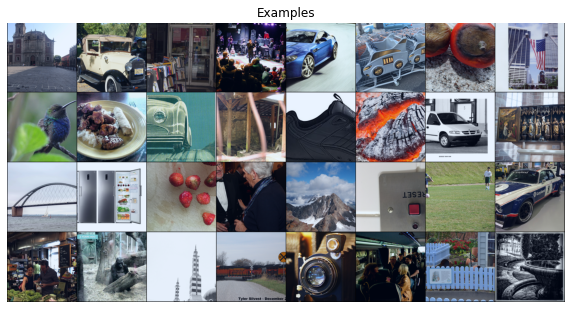

In [10]:
## show some examples in dataset
example_batch = next(iter(data_loader))
print(example_batch[0].shape) # image_batch shape

plt.figure(figsize=(10,20)) # 4x8 grid
plt.axis('off')
plt.title('Examples')
plt.imshow(np.transpose( # BCWH => BWHC
    make_grid(example_batch[0], padding=2, normalize=True),
    (1,2,0)
))

## Step2: load pretrained model to attack

In [14]:
## load pretrained model and set it to eval mode
# model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V2).eval()
model = torch.load(root+model_path)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
## tune it on eval mode
model.eval()
## fix the model's parameters
for param in model.parameters():
    param.requires_grad = False

## Step3: evaluate model before attack

In [16]:
## get true labels and corresponding predicted labels
predict_labels = [] # (num_imgs,)
true_labels = [] # (num_imgs,)

for img,true_label,_ in data_loader:
    # get true label
    true_labels += np.argmax(true_label.numpy(), # (batch_size, num_labels)
                             axis=1).tolist() # (batch_size,)
    # get predict label
    output = model(img) # (batch_size, num_labels)
    predict_label = np.argmax(output.detach().numpy(),axis=1).tolist() # (batch_size,)
    predict_labels += predict_label

In [17]:
## show some classification metrics report
metrics_dict = {
    'accuracy'      : metrics.accuracy_score,
    'precision'     : metrics.precision_score,
    'recall'        : metrics.recall_score,
    'F1'            : metrics.f1_score
}

for metric_name in metrics_dict.keys():
    score = 0.0
    if metric_name in ['precision','recall','F1']: # @param{average} is 'binary' by default, set it as 'macro'
        score = metrics_dict[metric_name](true_labels,predict_labels,average='macro',zero_division=1)
    else:
        score = metrics_dict[metric_name](true_labels,predict_labels)
    print("The {} score of the model before attack is {} %".format(
        metric_name, round(score*100,2) 
    ))

The accuracy score of the model before attack is 94.79 %
The precision score of the model before attack is 93.81 %
The recall score of the model before attack is 95.19 %
The F1 score of the model before attack is 91.23 %


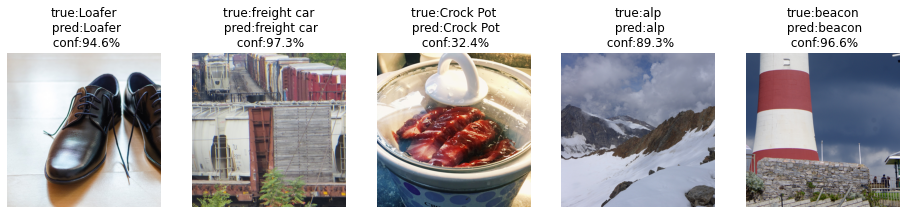

In [18]:
## show some prediction examples
example_size = 5
example_idxs = np.random.randint(0,len(dataset),(example_size,))
example_imgs = [dataset[idx][0] for idx in example_idxs]
example_imgs = torch.stack(example_imgs, dim=0) # tensor shape = (example_size, img_shape)

output = model(example_imgs) # shape = (example_size, num_classes)
true = [dataset.get_name(torch.argmax(dataset[idx][1]).numpy().item())[0] for idx in example_idxs] # shape = (example_size,1)
pred = [dataset.get_name(label)[0] for label in torch.argmax(output.detach(),dim=1).numpy().tolist()] # shape = (example_size,1)
conf = torch.max(torch.softmax(output.detach(),dim=1),dim=1)[0].numpy().tolist() # shape = (example_size,1)

plt.figure(figsize=(16,40))
plt.tight_layout()
for i in range(example_size):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.title("true:{}\n pred:{}\n conf:{}%".format(
        true[i], pred[i], round(conf[i]*100,1)
    ))
    plt.imshow(
        np.transpose(example_imgs[i] * 
                     torch.tensor(norm_std).view((-1,1,1)) + torch.tensor(norm_mean).view((-1,1,1)) # un-normalization
                     ,(1,2,0)) 
    )

## Step4: find adversarial examples using C&W attack

$\Rightarrow optimization\; problem:$

$$
\begin{aligned}
& \min\limits_{\eta=\tilde{x}-x} \; \mathrm{dist}(x,\tilde{x}) + c\cdot \mathrm{loss}(\tilde{x})\\
& s.t. \; \tilde{x} \in [0,1]^n,\; c>0\;, 
	\mathrm{label}(\tilde{x}) = y_{target} \iff \mathrm{loss}(\tilde{x})\le 0
\end{aligned}
$$

$\Rightarrow dist\; function\; options:$

$$
\begin{aligned}
& L_0: \; \mathrm{dist}(x,\tilde{x}) = ||\eta||_0 = \sum I(\eta_i\neq 0)\\
& L_2: \; \mathrm{dist}(x,\tilde{x}) = ||\eta||_2 = \sqrt{\sum \eta_i^2}\;\;\;\;\;\;\;\; (\eta = x-\tilde{x})\\
& L_{\infty}: \; \mathrm{dist}(x,\tilde{x}) = ||\eta||_{\infty} = \max\{\eta_i\}\\
\end{aligned}
$$

$\Rightarrow loss\; function\; options:$

$$
def.\begin{cases}
	& f(x) = \mathrm{softmax}[z(x)]\\
	& \mathrm{ErrConf}_f(x) =  [\max\limits_{i\neq target}f_i(x)]-f_{target}(x)\\
	& \mathrm{CrossEntropy}_{f,j}(x)= E_{y\sim onehot(j)}[-\log f(x)]\\
	\end{cases}\\
$$

$$
\begin{aligned}
	& \mathrm{loss}_1(\tilde{x}) = -\mathrm{CrossEntropy}_{f,target}(\tilde{x}) + 1\\
	& \mathrm{loss}_2(\tilde{x}) = \max\{\mathrm{ErrConf}_f(\tilde{x}),-k\}\\
	& \mathrm{loss}_3(\tilde{x}) = \mathrm{softplus}\{\mathrm{ErrConf}_f(\tilde{x})\}-\log 2\\
	& \mathrm{loss}_4(\tilde{x}) = \max\{0.5-f_{target}(\tilde{x}),-k\}\\
	& \mathrm{loss}_5(\tilde{x}) = -\log[2f_{target}(\tilde{x})-2]\\
	& \mathrm{loss}_6(\tilde{x}) = \max\{\mathrm{ErrConf}_z(\tilde{x}),-k\}\\
	& \mathrm{loss}_7(\tilde{x}) = \mathrm{softplus}\{\mathrm{ErrConf}_z(\tilde{x})\}-\log 2\\
\end{aligned}
$$

$\Rightarrow Box\; constraint\; options:$

$$
\begin{aligned}
\tilde{x} \in [0,1]^n \Rightarrow
\begin{cases}
	\mathrm{PGD}\;(Projected\;Gradient\;Descent) &: \; \tilde{x}_{i+1} = \Pi^{\infty}_{x,\epsilon}\{\tilde{x}_i + \eta_i \}\\
	\mathrm{CGD}\;(Clipped\;Gradient\;Descent)&: \; \mathrm{loss}_{cgd,i}(\tilde{x}) = \mathrm{loss}_i\{\min[\max(\tilde{x},0),1]\}\\
	\mathrm{CoV}\;(Change\;of\;Variables) &: \; \begin{cases}
    \eta_i = \cfrac{1}{2}[\mathrm{tanh}(\omega_i)+1]-\tilde{x}_i,\\
    \mathrm{tanh}(\omega_i) \in [-1,1]^n \Rightarrow \tilde{x}_{i+1}=\tilde{x}_i+\eta_i=\cfrac{1}{2}[\mathrm{tanh}(\omega_i)+1]\in [0,1]^n
    \end{cases}
\end{cases}\\
\end{aligned}
$$

In [19]:
## define C&W Attack Algorithm class
class CWAttack():
    """C&W algorithm for targeted adversarial attack"""
    def __init__(self,num_classes,lr=5e-3,bs_steps=5,max_iters=1000,init_c=1e-2,k=0):
        """
        @param{num_classes}: the number of classes
        @param{lr}: the learning rate to find adversarial examples => default value = 1e-3
        @param{bs_steps}: the max steps to binary search best trade-off const c => default value = 5
        @param{max_iters}: the max iterations to find adversarial example with certain trade-off const c => default value = 1e3
        @param{init_c}: the initial value of trade-off const c => default value = 1e-2
        @param{k}: the confidence used in loss func_{2,4,6} => default value = 0
        """
        # receive params
        self.num_classes = num_classes
        self.learning_rate = lr
        self.binary_search_steps = bs_steps
        self.max_iterations = max_iters
        self.init_const = init_c
        self.confidence = k
    def attack(self,x,y,model):
        """
        @param{x}: the images to attack => shape = (num_imgs,img_shape), range=[0,1]
        @param{y}: the corresponding target labels to attack => shape = (num_imgs,)
        #param{model}: the model we should attack => output of model(x) are logits with shape = (num_imgs,num_classes)
        """
        # init binary seach values
        lower_bound = [0.0] * len(x)
        upper_bound = [1e10] * len(x)
        c = x.new_ones(len(x),1) * self.init_const
        # init adversarial example logging values for total steps
        best_dist_tot = [float('inf')] * len(x)
        best_score_tot = [-1.0] * len(x)
        best_attack_tot = x.clone().detach()
        # change of variable => map imgs into tanh-space
        x_ori = x.clone().detach() # save the original x
        x = torch.clamp(x,0,1) * 2 - 1
        x = torch.arctanh(x * 0.999999)
        # init perturbation and onehot label
        perb = torch.zeros_like(x, requires_grad=True)
        y_onehot = y.clone() # shape = (num_imgs, num_classes)
        y = torch.argmax(y,dim=1) # shape = (num_imgs,1)
        # define dist-func, loss-func and optimizer
        dist_func = lambda x,y : torch.pow(x-y,2).sum( # using L2 dist func
            list(range(len(x.size())))[1:] # only sum in the image shape part
        )
        loss_func = lambda real,other : torch.max( # using loss func_6
            (other-real) + self.confidence, torch.tensor(0.0).to(real.device)
        )
        optimizer = Adam([perb], lr=self.learning_rate)
        # attack process
        for bs_step in range(self.binary_search_steps):
            # init adversarial example logging values for one binary search step
            best_dist = [float('inf')] * len(x)
            best_score = [-1.0] * len(x)
            # find adversarial examples with current trade-off const c
            for i in range(self.max_iterations):
                # forward
                x_tilde = (torch.tanh(x + perb) + 1) / 2
                output = model(x_tilde)
                real = torch.sum(y_onehot * output, dim=1)
                other,_ = torch.max((1-y_onehot) * output - y_onehot*1e4, dim=1)
                # backward
                optimizer.zero_grad()
                adv_loss = loss_func(real,other)
                dist_loss = dist_func(x_tilde,x_ori)
                loss = (dist_loss + c * adv_loss).sum()
                loss.backward()
                optimizer.step()
                # log
                for j,(dist_j,output_j,x_tilde_j) in enumerate(zip(dist_loss,output,x_tilde)):
                    succeeded = self.is_attacked(output_j,y[j],is_logits=True)
                    pred_j = torch.argmax(output_j)
                    if dist_j < best_dist_tot[j] and succeeded: # attack succeeded and find a closer one than total best
                        best_dist_tot[j],best_score_tot[j],best_attack_tot[j] = dist_j,pred_j,x_tilde_j 
                        best_dist[j],best_score[j] = dist_j,pred_j
                    elif dist_j < best_dist[j] and succeeded: # attack succeeded and find a closer one than this-step best
                        best_dist[j],best_score[j] = dist_j,pred_j
            # binary search for trade-off const c
            for j in range(len(x)):
                if self.is_attacked(best_score[j],y[j]) and best_score[j] != -1: # succeeded, divide into two
                    upper_bound[j] = min(upper_bound[j],c[j])
                    if upper_bound[j] < 1e9:
                        c[j] = (lower_bound[j]+upper_bound[j]) / 2
                else: # failed, either multiply by 10 if no valid value found, or divide in two
                    lower_bound[j] = max(lower_bound[j], c[j])
                    if upper_bound[j] < 1e9:
                        c[j] = (lower_bound[j]+upper_bound[j]) / 2
                    else:
                        c[j] *= 10
                        
        return best_attack_tot.detach()  
    def is_attacked(self,pred,label,is_logits=False):
        """a helper function to compare prediction against a target label , i.e. return true if attack succeeds"""
        if is_logits: # logits => predicted label
            pred_copy = pred.clone().detach()
            pred_copy[label] -= self.confidence
            pred = torch.argmax(pred_copy)
        return pred == label

In [20]:
## construct an attack using C&W algorithm
attacker = CWAttack(num_classes)
## set model on cuda if available
if torch.cuda.is_available:
    model.cuda()

In [21]:
## find adversarial examples for dataset
ori_imgs = [] # (num_imgs,img_shape)
adv_imgs = [] # (num_imgs,img_shape)
true_labels_adv = [] # (num_imgs,)
target_labels_adv = [] # (num_imgs,)
for i,(img,true_label,target_label) in enumerate(tqdm(iter(data_loader))): # for each batch
    adv_img = attacker.attack(x=img.to(device),y=target_label.to(device),model=model) # find adv examples for current batch
    # put corresponding original and adversarial images into two lists
    ori_imgs += [img[idx] for idx in range(len(img))]
    adv_imgs += [adv_img[idx] for idx in range(len(adv_img))]
    true_labels_adv += [true_label[idx] for idx in range(len(true_label))]
    target_labels_adv += [target_label[idx] for idx in range(len(target_label))]

In [22]:
## show some size information
print(len(ori_imgs))
print(len(adv_imgs))
print(len(true_labels_adv))
print(len(target_labels_adv))

883
883
883
883


## Step5: evaluate model after attack

In [27]:
## get predicted labels of adversarial images
adv_imgs_stk = torch.stack(adv_imgs, dim=0).cpu() # (num_imgs,img_shape)
print(adv_imgs_stk.shape)

model.cpu() # set model back on cpu
output = model(adv_imgs_stk) # (num_imgs, num_classes)
predict_labels_adv = torch.argmax(output.detach(),dim=1).numpy().tolist() # (num_imgs,)
print(len(predict_labels_adv))

torch.Size([883, 3, 299, 299])
883


In [39]:
## post-process true/target labels
true_labels_adv_copy = true_labels_adv.copy()
target_labels_adv_copy = target_labels_adv.copy()

true_labels_adv = [torch.argmax(true_labels_adv[idx]).detach().cpu().numpy().item() for idx in range(len(true_labels_adv))]
target_labels_adv = [torch.argmax(target_labels_adv[idx]).detach().cpu().numpy().item() for idx in range(len(target_labels_adv))]
print(len(true_labels_adv))
print(len(target_labels_adv))

883
883


In [40]:
# show some classification metrics report
metrics_dict = {
    'accuracy'      : metrics.accuracy_score,
    'precision'     : metrics.precision_score,
    'recall'        : metrics.recall_score,
    'F1'            : metrics.f1_score
}

for metric_name in metrics_dict.keys():
    score_ori = 0.0
    score_adv = 0.0
    if metric_name in ['precision','recall','F1']: # @param{average} is 'binary' by default, set it as 'macro'
        score_ori = metrics_dict[metric_name](true_labels,predict_labels,average='macro',zero_division=1)
        score_adv = metrics_dict[metric_name](true_labels_adv,predict_labels_adv,average='macro',zero_division=1)
    else:
        score_ori = metrics_dict[metric_name](true_labels,predict_labels)
        score_adv = metrics_dict[metric_name](true_labels_adv,predict_labels_adv)
    print("The {} score of the model before attack is {} %, but becomes {} % after attack".format(
        metric_name, round(score_ori*100,2), round(score_adv*100,2) 
    ))

The accuracy score of the model before attack is 94.79 %, but becomes 4.42 % after attack
The precision score of the model before attack is 93.81 %, but becomes 26.38 % after attack
The recall score of the model before attack is 95.19 %, but becomes 45.83 % after attack
The F1 score of the model before attack is 91.23 %, but becomes 2.34 % after attack


In [41]:
## show adversarial attack succeed-ratio
score_adv = metrics.accuracy_score(target_labels_adv,predict_labels_adv)
print("The adversarial attack succeed-ratio is {} %".format(
    round(score_adv*100,2)
))

The adversarial attack succeed-ratio is 95.13 %


In [54]:
## show some adversarial examples
example_size = 5
example_idxs = np.random.randint(0,len(ori_imgs),(example_size,))
example_imgs_ori = torch.stack([ori_imgs[idx].detach().cpu() for idx in example_idxs],dim=0) # (example_size, img_shape)
example_imgs_adv = torch.stack([adv_imgs[idx].detach().cpu() for idx in example_idxs],dim=0) # (example_size, img_shape)
print(example_imgs_ori.shape)
print(example_imgs_adv.shape)

torch.Size([5, 3, 299, 299])
torch.Size([5, 3, 299, 299])


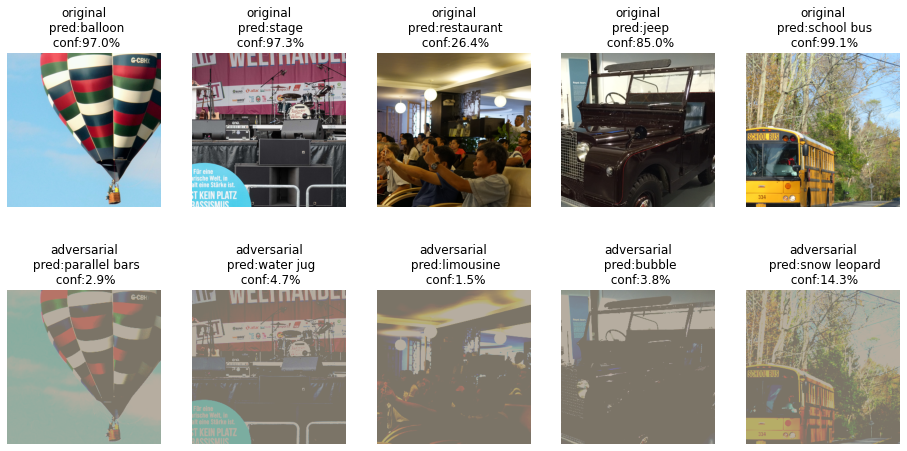

In [55]:
output_ori = model(example_imgs_ori) # shape = (example_size, num_classes)
output_adv = model(example_imgs_adv) # shape = (example_size, num_classes)

pred_ori = [dataset.get_name(label)[0] 
            for label in torch.argmax(output_ori.detach(),dim=1).numpy().tolist()] # shape = (example_size,1)
pred_adv = [dataset.get_name(label)[0] 
            for label in torch.argmax(output_adv.detach(),dim=1).numpy().tolist()] # shape = (example_size,1)

conf_ori = torch.max(torch.softmax(output_ori.detach(),dim=1),dim=1)[0].numpy().tolist() # shape = (example_size,1)
conf_adv = torch.max(torch.softmax(output_adv.detach(),dim=1),dim=1)[0].numpy().tolist() # shape = (example_size,1)

fig = plt.figure(figsize=(16,8))
for i in range(2*example_size):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    if i < example_size: # original
        plt.title("original\n pred:{}\n conf:{}%".format(
            pred_ori[i%example_size], round(conf_ori[i%example_size]*100,1)
        ))
        plt.imshow(
            np.transpose(example_imgs_ori[i%example_size] * 
                         torch.tensor(norm_std).view((-1,1,1)) + torch.tensor(norm_mean).view((-1,1,1)) # un-normalization
                         ,(1,2,0)) 
        )
    else:
        plt.title("adversarial\n pred:{}\n conf:{}%".format(
            pred_adv[i%example_size], round(conf_adv[i%example_size]*100,1)
        ))
        plt.imshow(
            np.transpose(example_imgs_adv[i%example_size] * 
                         torch.tensor(norm_std).view((-1,1,1)) + torch.tensor(norm_mean).view((-1,1,1)) # un-normalization
                         ,(1,2,0)) 
        )

## Step 6: summary

$\Rightarrow$ The C&W algorithm is a kind of optimization-based,white-box,targeted/untargeted adversarial attack method

$\Rightarrow$ Compared with the methods before, it got four highlight spots:

$\;\;\;\;\;$1. it summarizes three commonly-used distance measures, and compare the attack effects among them,

$\;\;\;\;\;\;\;\;$and it comes out that L2 distance is the best one relatively

$\;\;\;\;\;$2. it defines 7 different adversarial loss functions to satisify the attack constraint: $label(\tilde{x})=y_{target}$, 

$\;\;\;\;\;\;\;\;$some of which(like loss_func6) are widely used in the following researches

$\;\;\;\;\;$3. it firstly adopts the CoV(Change-of-Variables) trick to satisify the box contraint: $\tilde{x}\in[0,1]$,

$\;\;\;\;\;\;\;\;$which overcomes the disadvantages of PGD(Projected Gradient Descent) and CGD(Clipped Gradient Descent), like gradient-vanishing

$\;\;\;\;\;$4. it uses binary search to find the best trade-off constance, which automates and accelarates the parameter tuning process 

$\Rightarrow$ As for this homework:

$\;\;\;\;\;$1. the original pretrained InceptionV3 model achieves great classification performance on DEV dataset with high confidence 

$\;\;\;\;\;$2. however, it fails on almost all of the adversarial images, with low confidence though  

$\;\;\;\;\;$3.the adversarial perturbations of C&W, as we can see from the examples, are covering the whole original image,

$\;\;\;\;\;\;\;\;$which are obviously perceptible but not strange at all (and I believe it could do better if the binary search steps(5) were larger)